# CRIES
### Counting Reads for Intronic and Exonic Segments
https://github.com/csglab/CRIES


**Step 1. Creating GTF annotation files**

Intron and exon annotations for `gencode.v34` made within my notebook named `build-genome.ipynb`. 

**Step 2. Mapping reads**

`STAR` 

**Step 3. Counting reads that map to intronic or exonic segments of each gene**

`featureCounts`
http://bioinf.wehi.edu.au/featureCounts/

In [46]:
!bash _sh/loop_featureCounts.sh ../other-bam/ ./ 

In [1]:
!multiqc counts/*_exons.txt.summary -f -n counts-exons-multiqc.html
!multiqc counts/*_introns.txt.summary -f -n counts-introns-multiqc.html

[INFO   ]         multiqc : This is MultiQC v1.9
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl/counts/kg1_t_1Aligned.sortedByCoord.out_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl/counts/kg1_t_2Aligned.sortedByCoord.out_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl/counts/kg1_t_3Aligned.sortedByCoord.out_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl/counts/kg1_u_1Aligned.sortedByCoord.out_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl/counts/kg1_u_2Aligned.sortedByCoord.out_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertl

Searching 30 files..  [####################################]  100%          
[INFO   ]  feature_counts : Found 30 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : counts-introns-multiqc.html
[INFO   ]         multiqc : Data        : counts-introns-multiqc_data
[INFO   ]         multiqc : MultiQC complete


In [1]:
import os
import subprocess
import glob
import warnings
import pandas as pd
import numpy as np

from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RRuntimeWarning)

**Step 4. Normalization** - REMBRANDTS

#### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.



In [2]:
stbldir = '/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-stbl'

Prepare inputs:

In [3]:
# list path to intron and exon count files 
exon_count_files = glob.glob(f'{stbldir}/counts/*_exons.txt')
intron_count_files = glob.glob(f'{stbldir}/counts/*_introns.txt')

# define gene_ids for each count results for exon and intron 
exon_gene_ids = pd.read_table(exon_count_files[0], skiprows=1)['Geneid'].tolist()
intron_gene_ids = pd.read_table(intron_count_files[0], skiprows=1)['Geneid'].tolist()

# read all count tables into one dataframe 
df_exon = pd.DataFrame({}, index=exon_gene_ids)
df_intron = pd.DataFrame({}, index=intron_gene_ids)

for f in exon_count_files:
    counts = pd.read_table(f, skiprows=1).iloc[:, -1].tolist()
    f_n = f.split('/')[-1].replace('Aligned.sortedByCoord.out_exons.txt', '')
    df_exon[f_n] = counts
for f in intron_count_files:
    counts = pd.read_table(f, skiprows=1).iloc[:, -1].tolist()
    f_n = f.split('/')[-1].replace('Aligned.sortedByCoord.out_introns.txt', '')
    df_intron[f_n] = counts

samples = df_exon.columns.tolist()
# reorder in to same column order as the meta table rows 
df_exon = df_exon[samples] 
df_intron = df_intron[samples] 

# select overlap gene_ids
overlaps = list(set(df_exon.index)&set(df_intron.index))
# subset by overlap gene_ids 
df_exon = df_exon.loc[overlaps, ]
df_intron = df_intron.loc[overlaps, ]

# write input counts 
for c in samples:
    df_exon.loc[:, c].to_csv(f'{stbldir}/counts/{c}_exons.ol.txt', sep='\t', header=None)    
    df_intron.loc[:, c].to_csv(f'{stbldir}/counts/{c}_introns.ol.txt', sep='\t', header=None)

### Prepare REMBRANDTS inputs
# make meta data for running REMBRANDTS
labels = np.repeat(df_exon.columns.tolist(), 2)
files = [f'{labels[i]}_exons.ol.txt' if i%2==0 else f'{labels[i]}_introns.ol.txt' for i in range(len(labels))]
readtypes = ['exonic' if i%2==0 else 'intronic' for i in range(len(labels))]
meta = pd.DataFrame({'Label':labels, 'File':files, 'ReadType':readtypes, 'Batch':1})
meta.to_csv(f'{stbldir}/input_table.txt', index=False, sep='\t')

Run REMBRANDTS

In [5]:
import os
import subprocess
import pandas as pd 
# Run REMBRANDTS
os.chdir('/rumi/shams/abe/Workflows/REMBRANDTS/')
cmd = f'bash REMBRANDTS.sh Decitabine_treatment {stbldir}/input_table.txt {stbldir}/counts/ 0.99 linear'
subprocess.call(cmd , shell=True)

# remove results from previous run 
subprocess.call(f'rm -rv {stbldir}/output', shell=True)
subprocess.call(f'mv -v ./out/Decitabine_treatment/ {stbldir}/output', shell=True)
os.chdir(stbldir)

# clean results 
out = pd.read_table(f'{stbldir}/output/stability.filtered.mx.txt', index_col=0)
out.columns = [i.replace('.x','') for i in out.columns]

out.to_csv(f'{stbldir}/REMBRANDTS.txt', sep='\t')
print('\n********************************** Finished **********************************\n')


********************************** Finished **********************************



# Differential stability 
`Limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 

I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://www.bioconductor.org/packages/devel/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html

In [2]:
%reload_ext rpy2.ipython

In [4]:
%%R
library(edgeR)
library(Biobase)
library(rtracklayer)
library(tidyverse)

Read gene annotations into R 

In [5]:
%%R
GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

In [6]:
%%R 
# meta 
lines   <- lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist 
treats  <- rep(c(rep('treated',3), rep('DMSO',3)),5)
treats0 <- rep(c(rep('t',3), rep('u',3)),5)
reps    <- rep(c('rep1','rep2','rep3'),5)
reps0   <- rep(c('1','2','3'),5)

meta <- data.frame(
    line=lines, 
    cond=treats, 
    row.names=paste(lines, treats0, reps0, sep='_'),
    stringsAsFactors=FALSE
)
meta

               line    cond
kg1_t_1         kg1 treated
kg1_t_2         kg1 treated
kg1_t_3         kg1 treated
kg1_u_1         kg1    DMSO
kg1_u_2         kg1    DMSO
kg1_u_3         kg1    DMSO
molm14_t_1   molm14 treated
molm14_t_2   molm14 treated
molm14_t_3   molm14 treated
molm14_u_1   molm14    DMSO
molm14_u_2   molm14    DMSO
molm14_u_3   molm14    DMSO
ociaml2_t_1 ociaml2 treated
ociaml2_t_2 ociaml2 treated
ociaml2_t_3 ociaml2 treated
ociaml2_u_1 ociaml2    DMSO
ociaml2_u_2 ociaml2    DMSO
ociaml2_u_3 ociaml2    DMSO
ociaml3_t_1 ociaml3 treated
ociaml3_t_2 ociaml3 treated
ociaml3_t_3 ociaml3 treated
ociaml3_u_1 ociaml3    DMSO
ociaml3_u_2 ociaml3    DMSO
ociaml3_u_3 ociaml3    DMSO
thp1_t_1       thp1 treated
thp1_t_2       thp1 treated
thp1_t_3       thp1 treated
thp1_u_1       thp1    DMSO
thp1_u_2       thp1    DMSO
thp1_u_3       thp1    DMSO


In [77]:
%%R 
# Read `REMBRANDTS` results
counts <- read.table("REMBRANDTS.txt", row.names = 1, stringsAsFactors=FALSE, header=TRUE)
counts <- counts[,rownames(meta)]


In [78]:
%%R 
# Make annotation dataframe 
ann <- data.frame(
    name=gene2name[rownames(counts),],
    row.names=rownames(counts)
)

# Create ExpressionSet object
eset <- ExpressionSet(
    assayData = as.matrix(counts),
    phenoData = AnnotatedDataFrame(meta),
    featureData = AnnotatedDataFrame(ann)
)

In [79]:
%%R 
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 2325 features, 30 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: kg1_t_1 kg1_t_2 ... thp1_u_3 (30 total)
  varLabels: line cond
  varMetadata: labelDescription
featureData
  featureNames: ENSG00000000460 ENSG00000001629 ... ENSG00000278311
    (2325 total)
  fvarLabels: name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  


In [75]:
%%R 
run_limma <- function (exp_name, eset, design, run_type, SORT='none'){
    print (exp_name)

    # Fit coefficients 
    fit <- lmFit(eset, design)
    # Calculate t-statistics 
    fit <- eBayes(fit)
    # Summarize results 
    results <- decideTests(fit)

    stats <- topTable(fit, adjust.method="fdr", number = nrow(fit), sort.by = SORT) 

    # build a data frame 
    df = stats %>% data.frame %>%  
        add_column(gene_name=fit$genes$name) %>% 
        dplyr::select('gene_name','logFC','AveExpr','P.Value', 'adj.P.Val') %>% 
        rownames_to_column('ensembl_id')  %>% arrange(across(everything(), desc))
    
    # fit model to input eset object 
    if (run_type == 'fit'){ return (fit) }
    
    # draw volcano-plot 
        if (run_type == 'vol'){ return (volcanoplot(fit,highlight = 6, names = fit$genes[,'name'], main = exp_name)) }
    
    # return results
    if (run_type == 'res'){ return (results) }
    
    # print results summary 
    if (run_type == 'res_sum'){ print (summary (results)) }
    
    # return stats
    if (run_type == 'stats'){ return(stats) }
    
    # prepare iGET friendly table and write to file 
    if (run_type == 'write4iget'){
        write.table(
            df[,c('ensembl_id','logFC')] , paste(exp_name,'_delta_stbl','.txt',sep=''), 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t'
        )
    }
    
    # Write final data frame into file
    if (run_type == 'write'){
        write.table(
            df, paste(exp_name,'_delta_stbl_table','.txt',sep=''), 
            quote = F, col.names=TRUE, row.names=FALSE,sep ='\t'
        )
    }

}

Here, I write results for each cell line into a seprate file which includes logFC and p.values, plus gene names and gene ids. 

## Principal Component Analysis (PCA)


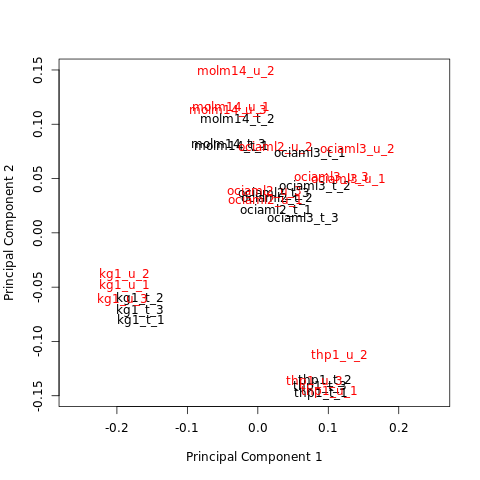

In [10]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),5)
mds = plotMDS(eset, labels = rownames(pData(eset)), 
        col=col_by_cond, top = 10000,
        gene.selection = "common")

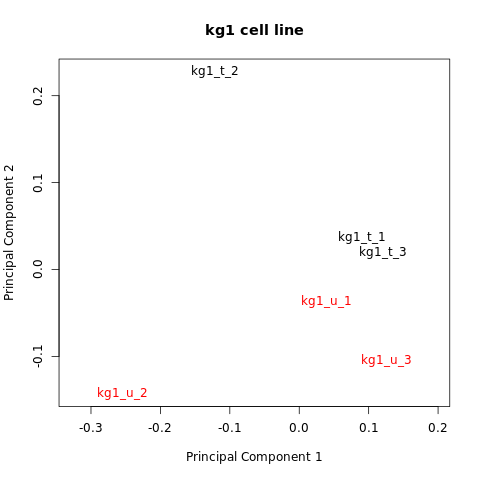

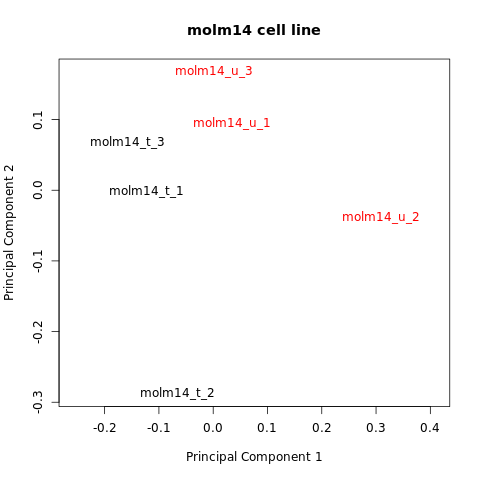

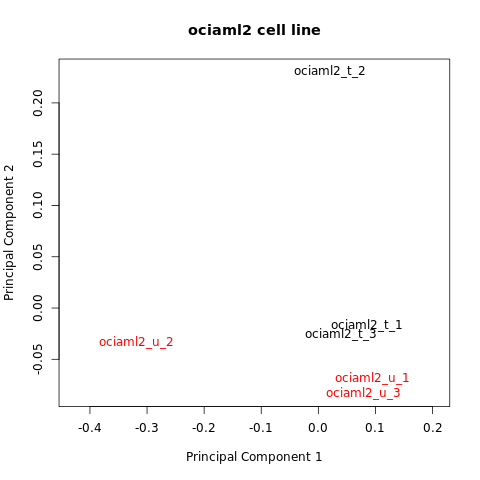

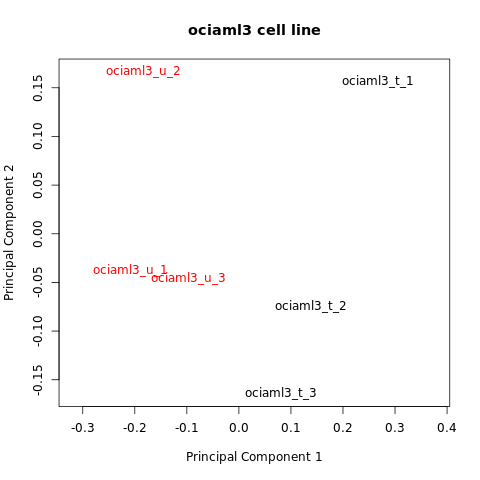

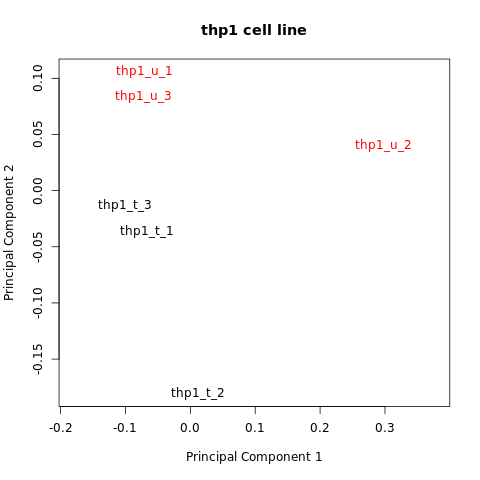

In [11]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=c(rep("black",3), rep("red",3)) # DMSO is red / treated is black
for (line in lines %>% unique){
    e = eset[,meta$line == line]
    plotMDS(e, labels = rownames(pData(e)),
            col=col_by_cond, main = paste (line, 'cell line'),
            gene.selection = "common")
    }

## Normalizing and filtering


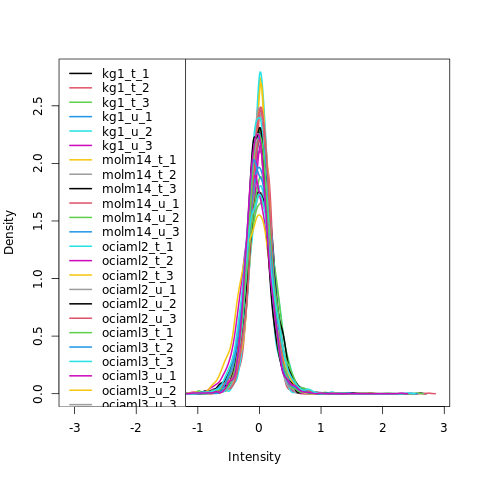

In [12]:
%%R 
# Create new ExpressionSet to store normalized data
eset_norm <- eset
# View the distribution of the raw data
p0 = plotDensities(eset_norm) #, legend = FALSE)

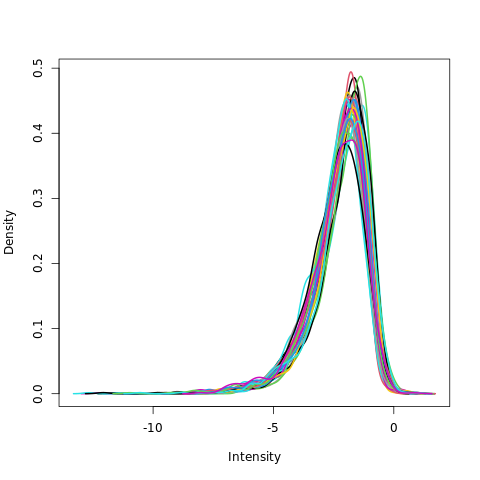

In [13]:
%%R
# Log tranform
exprs(eset_norm) <- log(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

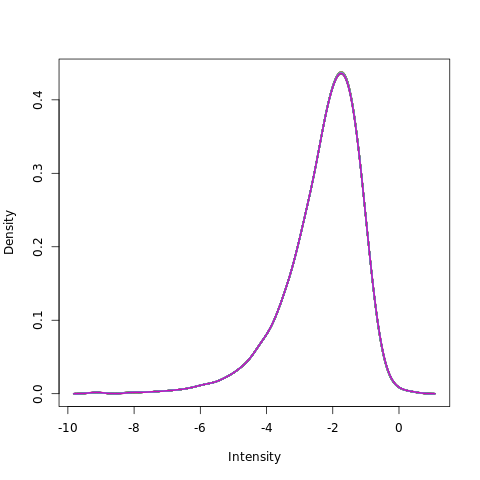

In [14]:
%%R
# Quantile normalize
exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

Let's write normalized RNA-Stabilities into a file. 

In [15]:
%%R 
ncu <- exprs(eset_norm) %>% replace_na(0)
write.table(ncu %>% 
            
            ,
            'stbl_norm_log_quantile.txt', sep="\t", quote=FALSE, col.names=TRUE)

In [34]:
%%R 
# ncu %>% add_column(fData(eset)[rownames(ncu),] %>% as.list %>% unlist ) %>% head 


R[write to console]: Error in vectbl_restore(out, .data) : 
  dims [product 69750] do not match the length of object [31]




Error in vectbl_restore(out, .data) : 
  dims [product 69750] do not match the length of object [31]


[1] "kg1"


R[write to console]: Removing intercept from test coefficients



[1] "kg1"


R[write to console]: Removing intercept from test coefficients



[1] "kg1"


R[write to console]: Removing intercept from test coefficients



[1] "molm14"


R[write to console]: Removing intercept from test coefficients



[1] "molm14"


R[write to console]: Removing intercept from test coefficients



[1] "molm14"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml2"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml2"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml2"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml3"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml3"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml3"


R[write to console]: Removing intercept from test coefficients



[1] "thp1"


R[write to console]: Removing intercept from test coefficients



[1] "thp1"


R[write to console]: Removing intercept from test coefficients



[1] "thp1"


R[write to console]: Removing intercept from test coefficients



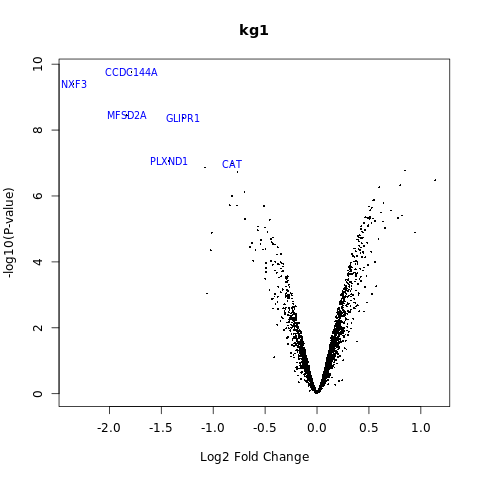

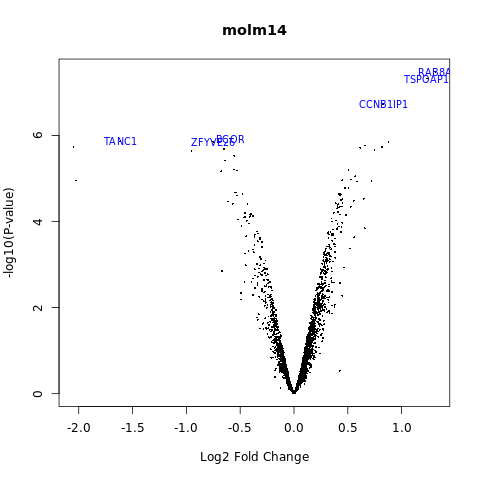

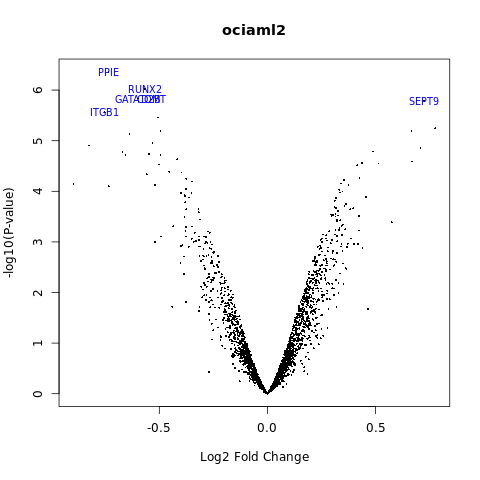

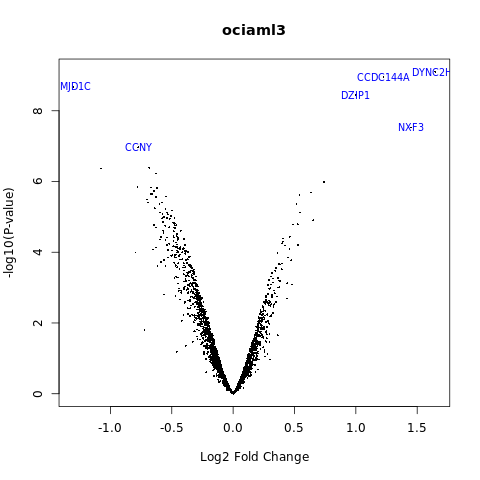

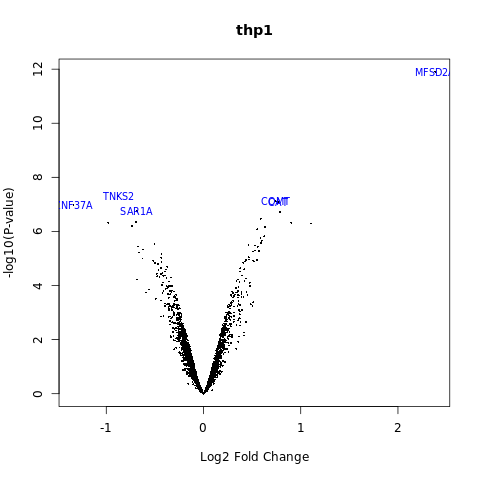

In [17]:
%%R 
Results= list()
Volcanos= list()
Stats= list()
for (line in lines %>% unique){

    e = eset[,meta$line == line]
    d = model.matrix(~cond, meta[meta$line == line,])
    Results[[line]] <- run_limma(line, e,d, 'res')
    Volcanos[[line]] <- run_limma(line, e,d, 'vol')
    Stats[[line]] <- run_limma(line, e,d, 'stats')
    
}

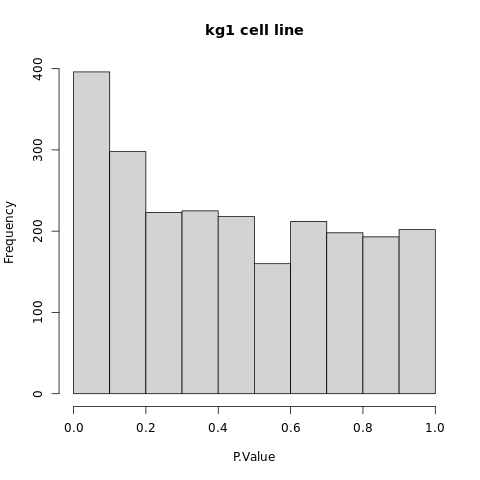

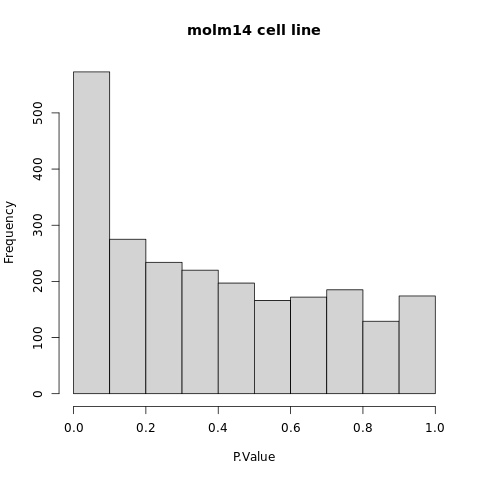

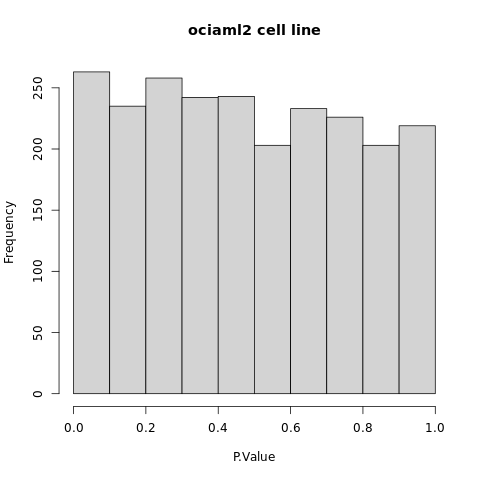

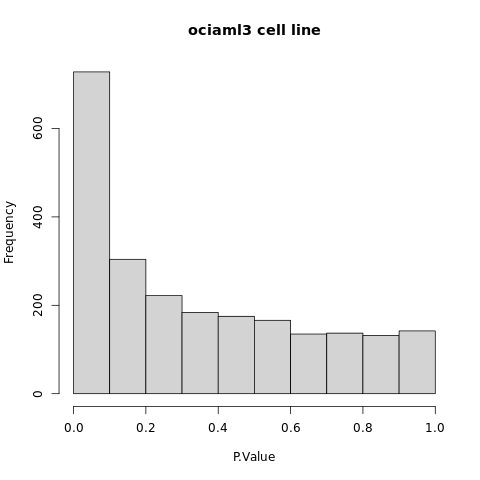

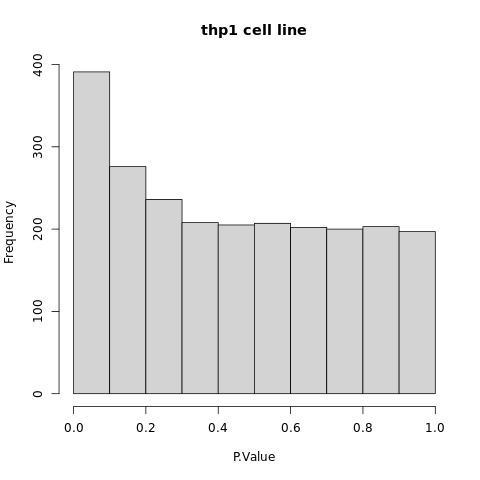

In [16]:
%%R 
# Create histograms of the p-values for each contrast
for (line in lines %>% unique){
    hist(Stats[[line]][, "P.Value"], main=paste(line, 'cell line'), xlab='P.Value')
}

## Clustering 

In [123]:
%%R 
sort_genes = dplyr::bind_cols(Stats) %>% 
    arrange(abs(across(starts_with("logFC")))) %>% 
   rownames

sig_genes = dplyr::bind_cols(Stats) %>% 
    filter(across(starts_with("P.Val")) < 0.005 | abs(across(starts_with("logFC"))) > 2) %>% 
    arrange(abs(across(starts_with("logFC")))) %>% 
   rownames


R[write to console]: New names:
* name -> name...1
* logFC -> logFC...2
* AveExpr -> AveExpr...3
* t -> t...4
* P.Value -> P.Value...5
* ...

R[write to console]: New names:
* name -> name...1
* logFC -> logFC...2
* AveExpr -> AveExpr...3
* t -> t...4
* P.Value -> P.Value...5
* ...



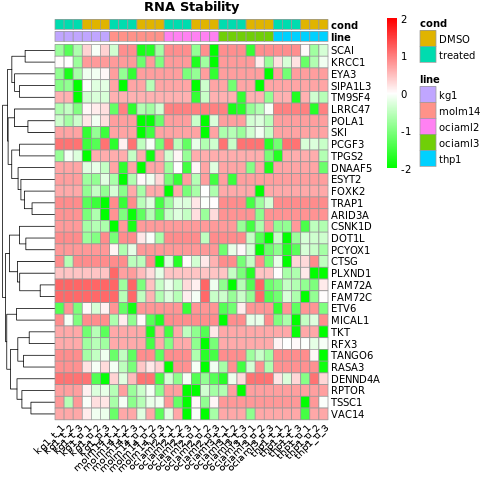

In [125]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[sig_genes, ]
rownames(sig_norm_counts) = ann[sig_genes,]

ann_colors = list(cond = c('DMSO'="blue", 'treated'="firebrick"))


colors <- c(seq(-2,2,by=0.01)) # ,max(sig_norm_counts))
my_palette <- c("green",colorRampPalette(colors = c("green", "white", "red"))
                                                   (n = length(colors)-3), "red")

# Plot heatmap
h1 = pheatmap(sig_norm_counts, 
         cluster_cols = F, 
         cluster_rows = T, 
         show_rownames = T,
         main = 'RNA Stability',
         annotation = select(meta, line, cond), 
         scale = 'row', 
         color = my_palette, 
             breaks = colors,margin = c(-2,2),
         angle_col= 45,
# #          legend_breaks = -1:1,
#          annotation_legend=T,
#          annotation_colors = ann_colors
            )



In [143]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering_top_hits.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h1$gtable)
dev.off()

png 
  2 


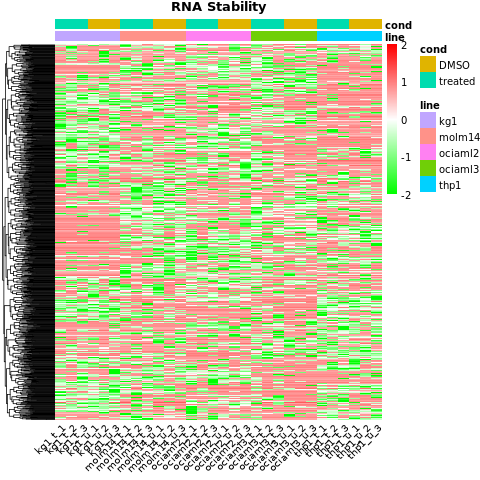

In [141]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[sort_genes[1:1000], ]
rownames(sig_norm_counts) = ann[sort_genes[1:1000],]

ann_colors = list(cond = c('DMSO'="blue", 'treated'="firebrick"))


colors <- c(seq(-2,2,by=0.01)) # ,max(sig_norm_counts))
my_palette <- c("green",colorRampPalette(colors = c("green", "white", "red"))
                                                   (n = length(colors)-3), "red")

# Plot heatmap
h2 = pheatmap(sig_norm_counts, 
         cluster_cols = F, 
         cluster_rows = T, 
         show_rownames = F,
         main = 'RNA Stability',
         annotation = select(meta, line, cond), 
         scale = 'row', 
         color = my_palette, 
         breaks = colors,margin = c(-2,2),
         angle_col= 45,
# #          legend_breaks = -1:1,
#          annotation_legend=F,
#          annotation_colors = ann_colors
            )



In [142]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h2$gtable)
dev.off()

png 
  2 


# Enrichment analysis 

Prepare inputs:

In [15]:
%%R 
for (line in lines %>% unique){
    e = NA; d = NA
    e = eset_norm[,meta$line == line]
    d = model.matrix(~cond, meta[meta$line == line,])
    run_limma(line, e,d, 'write4iget')
}

[1] "kg1"


R[write to console]: Removing intercept from test coefficients



[1] "molm14"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml2"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml3"


R[write to console]: Removing intercept from test coefficients



[1] "thp1"


R[write to console]: Removing intercept from test coefficients



In [40]:
%%bash
ipage=/rumi/shams/abe/Workflows/my_scripts/ipage_human_ensembl.sh 
nohup ls *delta_stbl.txt | parallel -j18 -k bash $ipage {} &> ipage.out &

In [ ]:
# %%R 
# # Extract the entrez gene IDs
# entrez <- rownames(fit2$genes) 
# # Test for enriched KEGG Pathways
# enrich_kegg <- kegga(fit2, geneid = entrez, species = 'Hs')

# # View the top 20 enriched KEGG pathways
# topKEGG(enrich_kegg)

# Write final results into text files 

In [80]:
%%R 
for (line in lines %>% unique){
    e = NA; d = NA
    e = eset[,meta$line == line]
    d = model.matrix(~cond, meta[meta$line == line,])
    run_limma(line, e,d, 'write')
}

[1] "kg1"


R[write to console]: Removing intercept from test coefficients



[1] "molm14"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml2"


R[write to console]: Removing intercept from test coefficients



[1] "ociaml3"


R[write to console]: Removing intercept from test coefficients



[1] "thp1"


R[write to console]: Removing intercept from test coefficients



In [113]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/limma/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12      RColorBrewer_1.1-2   forcats_0.5.0       
 [4] stringr_1.4.0        dplyr_1.0.1          purrr_0.3.4         
 [7] readr_1.3.1          tidyr_1.1.1          tibble_3.0.3        
[10] ggplot2_3.3.2        tidyverse_1.3.0      rtracklayer